# Adaptive Intelligence COM3240


## Assingment2


##Parameters to produce figures

| Figure | nRepetitions | nTrials | nSteps |learningRate | epsilon | gamma | Select algorithm|
| --- | --- | --- | --- | --- | --- | --- | --- |
| Figure 2 | 10 | 500 | 50 | 0.3 | 0.25 | 0.2 | Q-learning |
| Figure 3 | 10 | 500 | 50 | 0.3 | 0.25 | 1 | Q-learning |
| Figure 4 | 10 | 500 | 50 | 0.3 | 0.25 | 0.2 | SARSA |
| Figure 5 | 10 | 500 | 50 | 0.3 | 0.25 | 1 | SARSA |
| Figure 6 | 10 | 500 | 50 | 0.5 | 0.25 | 1 | Both |
| Figure 7 | 10 | 500 | 50 | 0.5 | 0.0 | 1 | Both |
| Figure 8 | 10 | 500 | 50 | 0.5 | 0.8 | 1 | Both |
| Figure 9 | 10 | 500 | 50 | 0.9 | 0.25 | 1 | Both |
| Figure 10 | 10 | 500 | 50 | 0.1 | 0.25 | 1 | Both |
| Figure 11 | 10 | 500 | 50 | 0.3 | 0.25 | 1 | Q-learning |
| Figure 12 | 10 | 500 | 50 | 0.3 | 0.25 | 1 | SARSA |




#### Script that returns the reward curve for each trial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(100)

def homing_nn(n_trials, n_steps, learning_rate, eps, gamma, algorithm):

    lam = 0.9
    
    ## Definition of the environment
    N = 4                               #height of the gridworld ---> number of rows
    M = 12                              #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    
    # Initialise a matrix where each row is one of the possible state vectors.
    states_matrix = np.eye(N_states)
    
    # 4 possible actions to move to each adjacent square
    N_actions = 4                                           
    action_change = np.array( [ [ 0, +1],
                                [+1, 0],
                                [ 0, -1],
                                [-1, 0]])
    action_labels = ['Right', 'Down', 'Left', 'Up'] 
    
    #setup cliff region
    cliff = np.array([[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10]]) 

    End = np.array([0, 11])                                     #terminal state--->reward
    s_end = np.ravel_multi_index(End, dims=(N, M), order='F')   #terminal state. Conversion in single index

    ## Rewards
    R_end = 10                              #only when the robot reaches the charger, sited in End state

    ## Variables
    # Weight matrix to predict the Q-values for eah action in a given state
    weights = np.random.rand(N_actions, N_states)*0.0
    
    # Eligibility value
    e = np.zeros((N_actions, N_states))
    
    # Reward curve: Here we will store the number of reward taken per trial
    Rewards = np.zeros((n_trials))
    
    ## SARSA and Q-learning Algorithm

    # Start trials
    for trial in range(n_trials):

        # Initialization
        #Start = np.array([np.random.randint(N), np.random.randint(M)]) #random start
        Start = np.array([0, 0])                                        #Set start to (0,0)
        s_start = np.ravel_multi_index(Start, dims=(N,M), order='F')    #conversion in single index
        state = Start                                                   #set current state
        s_index = s_start                                               #conversion in single index
        step = 0

        # First step for SARSA or Q-learning
        
        # convert the state into an input vector
        x = states_matrix[s_index]         
   
        # Q-value using a neural network
        Q = np.matmul(weights, x)
        
        # Greedy policy to select the most rewarding action
        #action = np.argmax(Q)      
        
        # eps-greedy policy implementation
        # If algorithm is SARSA, it will execute the eps-greedy policy below
        #output = np.zeros((N_actions))  
        if algorithm == "SARSA":
          action = np.argmax(Q)
          greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
          if greedy:
              action = np.argmax(Q)                           #pick best action
          else:
              action = np.random.randint(N_actions)           #pick random action
   
          # Setup the output array 
          output = np.zeros((N_actions))                     
          output[action] = 1

        # Begin steps iteration 
        for step in range(n_steps):
            
            # Uncomment for setup eligibility trace
            #e = e + np.outer(output, x)
            
            #If algorithm is Q-learning, it will execute the eps-greedy policy below
            if algorithm == "Q-learning":
              greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
              if greedy:
                  action = np.argmax(Q)                           #pick best action
              else:
                  action = np.random.randint(N_actions)           #pick random action

                            
              # Setup the output array (1 where action was taken, 0 otherwise)
              output = np.zeros((N_actions))                     
              output[action] = 1
            
            # Apply selected action to move to give a new state 
            state_new = state + action_change[action]
                    
            #put the robot back in grid if it goes out. Consider also the option to give a negative reward
            if state_new[0] < 0:
                state_new[0] = 0
            if state_new[0] >= N:
                state_new[0] = N-1
            if state_new[1] < 0:
                state_new[1] = 0
            if state_new[1] >= M:
                state_new[1] = M-1
            
            # Convert the new position into an index
            s_index_new = np.ravel_multi_index(state_new, dims=(N,M), order='F')    

            # If the agent reaches the end
            if (s_index_new == s_end):
                # convert the state into an input vector (S')
                x_new = states_matrix[s_index_new]
                
                r = R_end
                

                Rewards[trial] += R_end
                # Calculate the weight update with the immediate reward
                dw = learning_rate * (r - Q[action]) * np.outer(output, x)
                # Uncomment for update with eligibility trace
                #dw = learning_rate * (r - Q[action]) * e
                weights += dw 
                break
                
            # If the agent didn't reach the end
            else:
                # If the agent is in a cliff region
                if any((np.array_equal(a,state_new) for a in cliff)):                 
                  # convert the state into an input vector (S')
                  x_new = states_matrix[s_index_new]
                  
                  # Set reward to -100
                  r = -100
                  # Update reward curve
                  Rewards[trial] -= 100
                  # Calculate the weight update with the immediate reward
                  dw = learning_rate * (r - Q[action]) * np.outer(output, x)
                  # Uncomment for update with eligibility trace
                  #dw = learning_rate * (r - Q[action]) * e
                  weights += dw 
                  break
                else: 
                  Rewards[trial] -= 1
                  r = -1
                
                  # convert the state into an input vector (S')
                  x_new = states_matrix[s_index_new]
                  
                  # Predict the new Q-values
                  Q_new = np.matmul( weights, x_new)
                  
                  # If the choosen algorithm is Q-learning, action_new will always selected with greedy policy
                  if algorithm == "Q-learning":
                    action_new = np.argmax(Q_new)     
                  
                  # If the choosen algorithm is Q-learning, action_new will always selected with eps-greedy policy
                  if algorithm == "SARSA":
                    greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
                    if greedy:
                        action_new = np.argmax(Q_new)                       #pick best action
                    else:
                        action_new = np.random.randint(N_actions)           #pick random action

              
                  # Setup the output vector
                  output_new = np.zeros((N_actions))
                  output_new[action_new] = 1
                  
                  # Calculate the weight updates using SARSA or Q-learning
                  dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new]) * np.outer(output, x)
                  #dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new]) * e
                  weights += dw
            
            #e *= gamma*lam
            
            # Replace the old values with the new ones ready for the next step
            state = np.copy(state_new)
            if algorithm == "SARSA":
              action = np.copy(action_new)
            Q = np.copy(Q_new)
            output = np.copy(output_new)
            x = np.copy(x_new)
            s_index = s_index_new

    #Find the prefer direction
    prefer_direction = np.zeros((N*M))
    
    #Return the prefer direction for each state after all weight update is done
    for x in range(48):
      temp = []
      for y in range(4):
        temp.append(weights[y][x])
      prefer_direction[x] = np.argmax(temp)

    return Rewards,prefer_direction


#### Call the function homing_nn


In [ ]:
# Parameter setup
nRepetitions = 10;   # number of runs for the algorithm
nTrials =  500;      # should be integer >0
nSteps = 50;        # maximum number of allowed steps
learningRate = 0.3; # should be real, Greater than 0
epsilon = 0.25;     # should be real, Greater or Equal to 0; epsion=0 Greedy, otherwise epsilon-Greedy
gamma = 1;        # should be real, positive, smaller than 1

reward_curves = np.zeros((nRepetitions, nTrials))   #reward curve for the first algorithm
reward_curves2 = np.zeros((nRepetitions, nTrials))  #reward curve for the second algorithm
prefer_dir1 = np.zeros((nRepetitions,48))           #prefer directions for the first algorithm
prefer_dir2 = np.zeros((nRepetitions,48))           #prefer directions for the first algorithm
# Average number of steps to finish the task per trial for nRepetitions
for i in range(nRepetitions):
    reward_curves[i],prefer_dir1[i] = homing_nn(nTrials, nSteps, learningRate, epsilon, gamma, "Q-learning")
for i in range(nRepetitions):
    reward_curves2[i],prefer_dir2[i] = homing_nn(nTrials, nSteps, learningRate, epsilon, gamma, "SARSA")

In [ ]:
from collections import Counter

#Find which direction apear the most often for each state
def find_most_repeat(prefer_array):
  most_repeat = np.zeros((48))
  for i in range(48):
    temp = []
    for l in range(nRepetitions):
      temp.append(prefer_array[l][i])
    counts = np.bincount(temp)
    most_repeat[i] = np.argmax(counts)
  return(most_repeat)

most_repeat1 = find_most_repeat(prefer_dir1)
most_repeat2 = find_most_repeat(prefer_dir2)

In [ ]:
action_labels = ['Right', 'Down', 'Left', 'Up'] 
final_most_repeat1 = []
final_most_repeat2 = []

#Transfer the direction value into string
for i in range(48):
  final_most_repeat1.append(action_labels[int(most_repeat1[i])])
print(final_most_repeat1)
for i in range(48):
  final_most_repeat2.append(action_labels[int(most_repeat2[i])])
print(final_most_repeat2)

['Down', 'Right', 'Up', 'Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Up', 'Right', 'Right', 'Right', 'Up', 'Right', 'Right', 'Up', 'Up', 'Right', 'Right', 'Right', 'Up', 'Right', 'Right', 'Up', 'Up', 'Right', 'Up', 'Up', 'Up']
['Down', 'Down', 'Right', 'Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Down', 'Down', 'Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Down', 'Down', 'Right', 'Right', 'Right', 'Down', 'Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Down', 'Down', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Up', 'Up', 'Up']


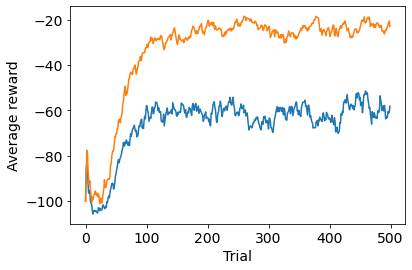

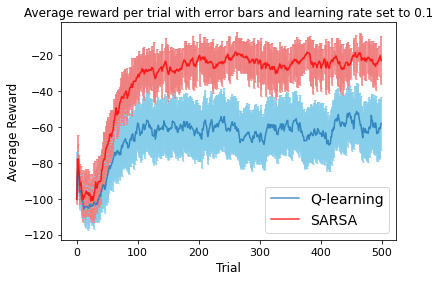

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 14})

pre_exponential_average = pd.DataFrame({'learning_curves': reward_curves.mean(axis=0)})
pre_exponential_average2 = pd.DataFrame({'learning_curves2': reward_curves2.mean(axis=0)})

exponential_average = pre_exponential_average.ewm(com=8).mean().to_numpy()   #get exponential average for first curve
exponential_average2 = pre_exponential_average2.ewm(com=8).mean().to_numpy() #get exponential average for second curve

std_reward_curves = np.std(reward_curves, axis=0)/ np.sqrt(nRepetitions)     #Get the standard deviation for first curve
std_reward_curves2 = np.std(reward_curves2, axis=0)/ np.sqrt(nRepetitions)   #Get the standard deviation for second curve

#Plot without error bar
plt.plot(exponential_average)                  
plt.plot(exponential_average2)
plt.xlabel('Trial')
plt.ylabel('Average reward')
plt.show()


# Plot with error bar
fig,(ax1)=plt.subplots(1,1)
fontSize = 12
ax1.set_title('Average reward per trial with error bars and learning rate set to 0.1',fontsize = 12)
ax1.set_xlabel('Trial',fontsize = fontSize)
ax1.set_ylabel('Average Reward',fontsize = fontSize)
ax1.tick_params(axis = 'both', which='major', labelsize = 11)

error_bar1 = ax1.errorbar(np.arange(nTrials), exponential_average, std_reward_curves, 0, ecolor='skyblue', elinewidth = 2, capsize = 1, alpha =0.8)
error_bar1[0].set_label('Q-learning')
error_bar2 = ax1.errorbar(np.arange(nTrials), exponential_average2, std_reward_curves2, 0,color = 'red', ecolor='lightcoral', elinewidth = 2, capsize = 1, alpha =0.8)
error_bar2[0].set_label('SARSA')
ax1.legend()

plt.savefig("output.jpg")
plt.show()
